In [1]:
import os
import cv2 as cv
import time
import random
import warnings
import sys


import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
IMG_CHANNELS = 3

Using TensorFlow backend.


In [2]:
def acc_comp(msk, preds_test_t):
    
    act = msk.reshape(len(msk),1)
    pr = preds_test_t

    c = act == pr
    d = act & pr
    e = act | pr
    neg = act.sum()
    pos = (len(act))-act.sum()

    TN = float(d.sum())
    FN = float(pr.sum()-d.sum())
    TP = float((len(act))-e.sum())
    FP = float(e.sum()-pr.sum())
    acc = float(c.sum())/(len(act))

    acc2 = float(TP+TN)/(TP+TN+FP+FN)
#     mean_TP = round(TP/pos,6)
#     mean_TN = round(TN/neg,6)
#     mean_FP = round(FP/pos,6)
#     mean_FN = round(FN/neg,6)
    
    return (acc,TP,TN,FP,FN)

In [3]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback() 

In [4]:
# Dataset 1: HGR
# TRAIN_PATH1 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset1_HGR/original_images/']
# MASK_PATH1 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset1_HGR/skin_masks/']
# train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
# mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
# train_ids1.sort()
# mask_ids1.sort()
# TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
# MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 2: TDSD
# TRAIN_PATH5 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset2_TDSD/original_images/']
# MASK_PATH5 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset2_TDSD/skin_masks/']
# train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
# mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
# train_ids5.sort()
# mask_ids5.sort()
# TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
# MASK_PATH5 = MASK_PATH5*len(train_ids5)

# # Dataset 3: Schmugge
# TRAIN_PATH6 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset3_Schmugge/original_images/']
# MASK_PATH6 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
# train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
# mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
# train_ids6.sort()
# mask_ids6.sort()
# TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
# MASK_PATH6 = MASK_PATH6*len(train_ids6)

# # Dataset 4: Pratheepan
# TRAIN_PATH2 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# MASK_PATH2 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
# train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
# mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
# train_ids2.sort()
# mask_ids2.sort()
# TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
# MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
# TRAIN_PATH3 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset5_VDM/original_images/']
# MASK_PATH3 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset5_VDM/skin_masks/']
# train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
# mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
# train_id3.sort()
# mask_id3.sort()
# train_ids3 = train_id3[1:]
# mask_ids3 = mask_id3[1:]
# TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
# MASK_PATH3 = MASK_PATH3*len(train_ids3)

# # Dataset 6: SFA
# TRAIN_PATH4 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset6_SFA/original_images/']
# MASK_PATH4 = ['/home/lalzogbi/Skin_Detection/Training_Data/Skin_Datasets/Dataset6_SFA/skin_masks/']
# train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
# mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
# train_ids4.sort()
# mask_ids4.sort()
# TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
# MASK_PATH4 = MASK_PATH4*len(train_ids4)

# # # Dataset 7: FSD
# TRAIN_PATH7 = ['/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/FSD-ECU-100/original_images/']
# MASK_PATH7 = ['/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/FSD-ECU-100/skin_masks/']
# train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
# mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
# train_ids7.sort()
# mask_ids7.sort()
# TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
# MASK_PATH7 = MASK_PATH7*len(train_ids7)

# Dataset 8: ABDOMEN
TRAIN_PATH8 = ['/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/original_images/']
MASK_PATH8 = ['/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/skin_masks/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

# # Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH1,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH7,TRAIN_PATH8))
# MASK_PATH = np.concatenate((MASK_PATH1,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH7,MASK_PATH8))
# train_ids = np.concatenate((train_ids1,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids7,train_ids8))
# mask_ids = np.concatenate((mask_ids1,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids7,mask_ids8))

In [48]:
 # Extract Features and Corresponding Labels (RUN ONCE ONLY TO GET THE DATA)    
TRAIN_PATH = TRAIN_PATH8;
train_ids = train_ids8;
MASK_PATH = MASK_PATH8;
mask_ids = mask_ids8;

print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = TRAIN_PATH[0] + train_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MASK_PATH[0] + mask_ids[0]
img = imread(path)
if img.ndim == 3:
    img = img[:,:,1]   
if (np.unique(img).size) > 2:
    img = img > 30     # Important, needed to make labels 0's and 1's only 
else:
    img = img > 0
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + train_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
        
    if (np.unique(img).size) > 2:
        img = img > 30     # Important, needed to make labels 0's and 1's only 
    else:
        img = img > 0
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

ABD_TEST = dat

Getting features and labels from images unreshaped... 


100%|██████████| 200/200 [00:05<00:00, 17.33it/s]


In [49]:
print(dat.shape)
print(np.sum(dat[:,9]))
np.random.shuffle(ABD_TEST)
np.save('ABD_TEST.npy',ABD_TEST)
print(np.unique(dat[:,9]))

(10357329, 10)
6550164
[0 1]


In [4]:
# Load the data then shuffle
# ABD = np.load('ABD_TRAIN.npy')

FSD = np.load('FSD_TRAIN.npy')

HGR = np.load('HGR.npy')

PR = np.load('PR.npy')

SCHMG = np.load('SCHMG.npy')

SFA = np.load('SFA.npy')

TDSD = np.load('TDSD.npy')

VDM = np.load('VDM.npy')

In [5]:
# Extract and Balance Data
# L=np.where(ABD[:,9] > 0)
# K = L[0]
# skin_abd = ABD[K[:]]
# skin_abd = skin_abd[:200000]
# L=np.where(ABD[:,9] == 0)
# K = L[0]
# noskin_abd = ABD[K[:]]
# noskin_abd = noskin_abd[:200000]

L=np.where(FSD[:,9] > 0)
K = L[0]
skin_fsd = FSD[K[:]]
skin_fsd = skin_fsd[:200000]
L=np.where(FSD[:,9] == 0)
K = L[0]
noskin_fsd = FSD[K[:]]
noskin_fsd = noskin_fsd[:200000]

L=np.where(HGR[:,9] > 0)
K = L[0]
skin_hgr = HGR[K[:]]
skin_hgr = skin_hgr[:200000]
L=np.where(HGR[:,9] == 0)
K = L[0]
noskin_hgr = HGR[K[:]]
noskin_hgr = noskin_hgr[:200000]

# L=np.where(PR[:,9] > 0)
# K = L[0]
# skin_pra = PR[K[:]]
# skin_pra = skin_pra[:30000]
# L=np.where(PR[:,9] == 0)
# K = L[0]
# noskin_pra = PR[K[:]]
# noskin_pra = noskin_pra[:70000]

L=np.where(SCHMG[:,9] > 0)
K = L[0]
skin_schmg = SCHMG[K[:]]
skin_schmg = skin_schmg[:200000]
L=np.where(SCHMG[:,9] == 0)
K = L[0]
noskin_schmg = SCHMG[K[:]]
noskin_schmg = noskin_schmg[:200000]

L=np.where(SFA[:,9] > 0)
K = L[0]
skin_sfa = SFA[K[:]]
skin_sfa = skin_sfa[:200000]
L=np.where(SFA[:,9] == 0)
K = L[0]
noskin_sfa = SFA[K[:]]
noskin_sfa = noskin_sfa[:200000]

L=np.where(TDSD[:,9] > 0)
K = L[0]
skin_tdsd = TDSD[K[:]]
skin_tdsd = skin_tdsd[:200000]
L=np.where(TDSD[:,9] == 0)
K = L[0]
noskin_tdsd = TDSD[K[:]]
noskin_tdsd = noskin_tdsd[:200000]

L=np.where(VDM[:,9] > 0)
K = L[0]
skin_vdm = VDM[K[:]]
skin_vdm = skin_vdm[:200000]
L=np.where(VDM[:,9] == 0)
K = L[0]
noskin_vdm = VDM[K[:]]
noskin_vdm = noskin_vdm[:200000]

In [6]:
# Load Shuffled data
# alldata = np.concatenate((ABD_TRAIN,FSD_TRAIN,HGR,VDM,SCHMG,SFA,TDSD,VDM), axis = 0)
alldata = np.concatenate((skin_hgr,skin_schmg,skin_sfa,skin_tdsd,skin_vdm,noskin_hgr,noskin_schmg,noskin_sfa,noskin_tdsd,noskin_vdm), axis = 0)
np.random.shuffle(alldata)
take = alldata[:1500000]
print(take.shape)
feat = take[:,:9]
labels = take[:,9]
labels = (labels > 0).astype(np.uint8)

(1500000, 10)


In [7]:
# Build the network
model = Sequential()
model.add(Dense(9, input_dim=9, activation='relu'))
model.add(Dropout(0.1, input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2, input_shape=(256,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3, input_shape=(32,)))
model.add(Dense(9, activation='relu'))
model.add(Dropout(0.3, input_shape=(9,)))
model.add(Dense(1, activation='sigmoid'))

checkpointer = ModelCheckpoint('without_abd.h5', verbose=1, save_best_only=True)
sgd = optimizers.SGD(lr=0.0003, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

results = model.fit(feat, labels, validation_split=0.2, epochs=50, batch_size=64, shuffle=True, 
          callbacks=[checkpointer, cb])

W0729 21:41:21.909446 139780900472576 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 21:41:21.929605 139780900472576 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 21:41:21.932385 139780900472576 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 21:41:21.946110 139780900472576 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:13

Train on 1200000 samples, validate on 300000 samples
Epoch 1/50
1200000/1200000 [==============================] - 162s 135us/step - loss: 0.4451 - acc: 0.8128 - val_loss: 0.3316 - val_acc: 0.8671

Epoch 00001: val_loss improved from inf to 0.33161, saving model to without_abd.h5
Epoch 2/50
1200000/1200000 [==============================] - 158s 131us/step - loss: 0.3715 - acc: 0.8552 - val_loss: 0.3321 - val_acc: 0.8629

Epoch 00002: val_loss did not improve from 0.33161
Epoch 3/50
1200000/1200000 [==============================] - 154s 128us/step - loss: 0.3619 - acc: 0.8596 - val_loss: 0.3235 - val_acc: 0.8712

Epoch 00003: val_loss improved from 0.33161 to 0.32348, saving model to without_abd.h5
Epoch 4/50
1200000/1200000 [==============================] - 158s 132us/step - loss: 0.3563 - acc: 0.8618 - val_loss: 0.3183 - val_acc: 0.8732

Epoch 00004: val_loss improved from 0.32348 to 0.31826, saving model to without_abd.h5
Epoch 5/50
1200000/1200000 [==============================]

1200000/1200000 [==============================] - 153s 128us/step - loss: 0.3355 - acc: 0.8726 - val_loss: 0.3253 - val_acc: 0.8765

Epoch 00041: val_loss did not improve from 0.31060
Epoch 42/50
1200000/1200000 [==============================] - 154s 128us/step - loss: 0.3350 - acc: 0.8728 - val_loss: 0.3258 - val_acc: 0.8738

Epoch 00042: val_loss did not improve from 0.31060
Epoch 43/50
1200000/1200000 [==============================] - 153s 128us/step - loss: 0.3355 - acc: 0.8730 - val_loss: 0.3196 - val_acc: 0.8757

Epoch 00043: val_loss did not improve from 0.31060
Epoch 44/50
1200000/1200000 [==============================] - 154s 129us/step - loss: 0.3351 - acc: 0.8731 - val_loss: 0.3247 - val_acc: 0.8742

Epoch 00044: val_loss did not improve from 0.31060
Epoch 45/50
1200000/1200000 [==============================] - 153s 128us/step - loss: 0.3348 - acc: 0.8729 - val_loss: 0.3259 - val_acc: 0.8748

Epoch 00045: val_loss did not improve from 0.31060
Epoch 46/50
1200000/1200000

In [ ]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [4]:
# Evaluate the model
# model1 = load_model('without_abd.h5')
# IMG_HEIGHT = 128
# IMG_WIDTH = 128
# IMG_CHANNELS = 3

# # # Compute Accuracy for Abdomen Set
# IMG_HEIGHT = 128
# IMG_WIDTH = 128
# IMG_CHANNELS = 3

# # Compute Accuracy for Abdomen Set
# ABD_PATH = '/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/original_images/'
# MSK_PATH = '/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/skin_masks/'

# # ABD_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# # MSK_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
# abd_ids = next(os.walk(ABD_PATH))[2]
# msk_ids = next(os.walk(MSK_PATH))[2]
# abd_ids.sort()
# msk_ids.sort()

# # ABD_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_SFA/original_images/']
# # MSK_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_SFA/skin_masks/']

# ABD_PATH = TRAIN_PATH8
# MSK_PATH = MASK_PATH8
# abd_ids = next(os.walk(ABD_PATH[0]))[2]
# msk_ids = next(os.walk(MSK_PATH[0]))[2]
# abd_ids.sort()
# msk_ids.sort()
# abd_ids = abd_ids[-100:]
# msk_ids = msk_ids[-100:]

# print('Getting features and labels from images unreshaped... ')
# sys.stdout.flush()

# scores = model.evaluate(X, Y)
# preds_test = model.predict(X, verbose=1)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Evaluate the model
# os.chdir('/home/lalzogbi/Skin_Detection/Code/Wound_Segmentation/models')
model = load_model('without_abd.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/original_images/'
MSK_PATH = '/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/skin_masks/'
# ABD_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# MSK_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()
# ABD_PATH = ABD_PATH*len(abd_ids)
# MSK_PATH = MSK_PATH*len(msk_ids)

# abd_ids = abd_ids[6:]
# msk_ids = msk_ids[6:]

# Actual Predictions
# N = np.zeros((1,4))
path = ABD_PATH + abd_ids[0]
print(path)
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
# img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]
    
    img = img > 30    
    img = img > 0
    img = img.astype(np.uint8)
    L = img.reshape(img.shape[0]*img.shape[1],1)
    
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

dat = np.load('ABD_TEST.npy')
   
X = dat[:,0:9]
Y = dat[:,9]

# scores = model.evaluate(X, Y)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

W0730 09:40:52.879929 140361315952384 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 09:40:52.899338 140361315952384 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 09:40:52.912286 140361315952384 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 09:40:52.913585 140361315952384 deprecation_wrapper.py:119] From /home/lalzogbi/Skin_Detection/Code/env/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:1

/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/original_images/0005.jpg


100%|██████████| 200/200 [00:06<00:00, 17.51it/s]


In [14]:
dat = np.load('ABD_TEST.npy')
model = load_model('model-masturbation-11Feb2019.h5')
   
X = dat[:,0:9]
Y = dat[:,9]

In [15]:
preds_test = model.predict(X[:int(X.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

answer = acc_comp(Y, preds_test_t)

# a = answer[1]
# b = answer[2]
# c = answer[3]
# d = answer[4]

# K = np.array((a,b,c,d)).reshape(1,4)
# # N = np.concatenate((N,K),axis = 0)
# print(K)

a = answer[1]
b = answer[2]
c = answer[3]
d = answer[4]
K = np.array((a,b,c,d)).reshape(1,4)
print(K.shape)

N = np.zeros((1,4))
N = np.concatenate((N,K),axis = 0)
out = N[1:]
j = (out[:,0]+out[:,1])/(out[:,0]+out[:,1]+out[:,2]+out[:,3])
print(np.mean(j))
print(N)

10357329/10357329 [==============================] - 437s 42us/step
(1, 4)
0.8671996419154011
[[      0.       0.       0.       0.]
 [2819452. 6162420.  387744.  987713.]]


In [ ]:
# np.save('abd_results.npy',K)
print(out)

In [21]:
# scores = model.evaluate(X, Y)
# preds_test = model.predict(X, verbose=1)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Evaluate the model
# os.chdir('/home/lalzogbi/Skin_Detection/Code/Wound_Segmentation/models')
model = load_model('without_abd.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/original_images/'
MSK_PATH = '/home/lalzogbi/Skin_Detection/Skin_Datasets/Test/Abdomen-200/skin_masks/'

# ABD_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
# MSK_PATH = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()
# ABD_PATH = ABD_PATH*len(abd_ids)
# MSK_PATH = MSK_PATH*len(msk_ids)
# print(len(abd_ids))

# abd_ids = abd_ids[6:]
# msk_ids = msk_ids[6:]

# Actual Predictions
# N = np.zeros((1,4))

# for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
path = ABD_PATH + abd_ids[21]
img = imread(path)[:,:,:IMG_CHANNELS]
t = img
#     img = resize(img, (128, 128), mode='constant', preserve_range=True).astype('uint8')
b = img.reshape(img.shape[0]*img.shape[1],3)

hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[21]
img = imread(path)
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
#                                       preserve_range=True).astype('uint8')

if img.ndim == 3:
    img = img[:,:,1]

img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)
dat_temp = np.concatenate((b,hsv,lab,L),axis=1)

X = dat_temp[:,0:9]
Y = dat_temp[:,9]
    
preds_test = model.predict(X[:int(X.shape[0])], verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# answer = acc_comp(Y, preds_test_t)

# a = answer[1]
# b = answer[2]
# c = answer[3]
# d = answer[4]

# K = np.array((a,b,c,d)).reshape(1,4)
# N = np.concatenate((N,K),axis = 0)
#     print(N)

51529/51529 [==============================] - 4s 68us/step


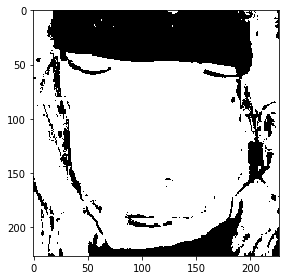

In [10]:
# print(preds_test_t.shape)
preds_test_t.reshape(t.shape[0],t.shape[1],1)
curly = preds_test_t.reshape(t.shape[0],t.shape[1])
imshow(curly*255)
plt.show()
# cv.imwrite('darkskinFeatures.jpg',curly*255)

In [12]:
# Overall accuracy on abdomen pictures
answer = acc_comp(Y, preds_test_t)
print(answer)

# a = answer[1]
# b = answer[2]
# c = answer[3]
# d = answer[4]
# K = np.array((a,b,c,d)).reshape(1,4)
# print(K.shape)

# N = np.zeros((1,4))
# N = np.concatenate((N,K),axis = 0)
# out = N[1:]
# j = (out[:,0]+out[:,1])/(out[:,0]+out[:,1]+out[:,2]+out[:,3])
# print(np.mean(j))
# np.save('pra-features.npy',out)

(0.886238816976848, 10111.0, 35556.0, 3916.0, 1946.0)


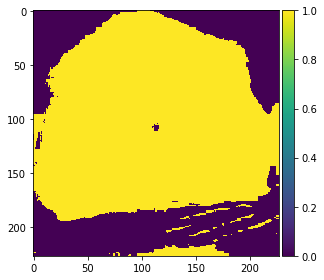

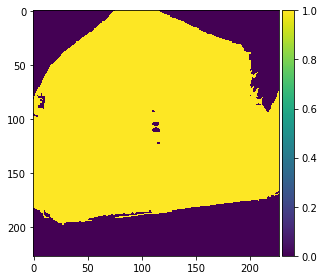

In [8]:
output = np.reshape(preds_test_t,(img.shape[0],img.shape[1]))
plt.show()
imshow(output)
plt.show()
imshow(img)

In [ ]:
feat = dat[0:800000,0:9]
labels = dat[0:800000,9]
labels = (labels > 0).astype(np.uint8)
print(feat.shape)
print(labels.shape)
X = dat[800000:,0:9]
Y = dat[800000:,9]
Y = (Y > 0).astype(np.uint8) 
print(X.shape)
print(Y.shape)